### Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline

### Exploratory Analysis

In [12]:
df = pd.read_csv("data.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 101.1 KB


The data doesn't have null or incomplete samples.

In [13]:
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


#### Quantitative properties.

In [14]:
quan_cols = ["age", "diff_sym_hos"]
df[quan_cols].describe()

,age,diff_sym_hos
count,863.000000,863.000000
mean,49.400000,0.995365
std,15.079203,2.358767
min,2.000000,-5.000000
25%,40.000000,0.000000
50%,49.400000,0.000000
75%,57.000000,1.000000
max,96.000000,15.000000


It appears that the patients are relatively old (mean of 49.) The median is 49, which makes the mean a good indicator.

Let's see how correlated is the age to the result.

In [15]:
df.groupby("result")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
0,755.0,46.463841,12.820090,2.0,38.0,49.4,55.0,81.0
1,108.0,69.925926,13.695421,8.0,65.0,72.5,76.0,96.0


0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

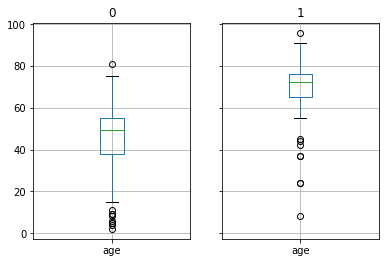

In [34]:
df.groupby("result").boxplot(column="age")

The mean age of the deceased patients is nearly 70 while the recoverd ones have a mean age of 46.46. Thus, the age is positively correlated with mortality rate.

#### Qualitative properties.

In [16]:
qual_cols = ["location", "gender", "vis_wuhan", "from_wuhan", *[f"symptom{i}" for i in range(1, 7)], "result"]

Let's have a look at whether visiting Wuhan has any relation with mortality rate.

In [28]:
df.groupby("result")["vis_wuhan"].value_counts(normalize=True)

result  vis_wuhan
0       0            0.796026
        1            0.203974
1       0            0.972222
        1            0.027778
Name: vis_wuhan, dtype: float64

<AxesSubplot:ylabel='result'>

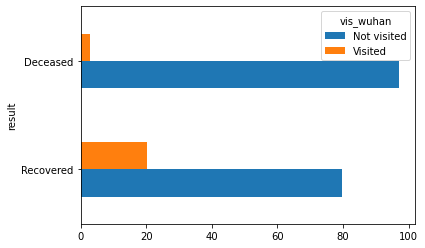

In [38]:
(df.groupby("result")["vis_wuhan"].value_counts(normalize=True) * 100).unstack() \
    .rename(columns={0: "Not visited", 1: "Visited"}, index={0: "Recovered", 1: "Deceased"}).plot.barh()

Contrary to stereotypes, most of the deceased didn't visit Wuhan (97%) while 20% of the recovered did actually visit Wuhan.

Let's see the relation between gender and mortality rate.

In [36]:
df.groupby("result")["gender"].value_counts(normalize=True)

result  gender
0       1         0.423841
        0         0.354967
        2         0.221192
1       1         0.638889
        0         0.314815
        2         0.046296
Name: gender, dtype: float64

<AxesSubplot:ylabel='result'>

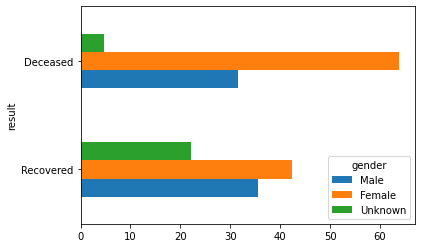

In [39]:
(df.groupby("result")["gender"].value_counts(normalize=True) * 100).unstack() \
    .rename(columns={0: "Male", 1: "Female", 2: "Unknown"}, index={0: "Recovered", 1: "Deceased"}).plot.barh()

Surprisingly, a considrable group of the deceased are females (63%) while only 42% of the recovered are females.
This suggests a correlation between females and mortality rate.

It's time to investigate the symptoms, which are expected to be highly correlated with the mortality rate.

In [ ]:
f = plt.figure()
f, axes = plt.subplots(nrows = 1, ncols = 2, sharey = True)
k = 0
for i in quan_cols:
    axes[int(k/1)][int(k%2)].plot(df[i], df['result'])
    axeape=1

### Learning and Training

#### KNN